<a href="https://colab.research.google.com/github/gal-dmitry/HSE_DUL/blob/hw_07/Homework7_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!if [ -d dul_2021 ]; then rm -Rf dul_2021; fi
!git clone https://github.com/GrigoryBartosh/dul_2021
!pip install ./dul_2021

Cloning into 'dul_2021'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (89/89), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 260 (delta 57), reused 51 (delta 51), pack-reused 171
Receiving objects: 100% (260/260), 53.34 MiB | 15.11 MiB/s, done.
Resolving deltas: 100% (118/118), done.
Processing ./dul_2021
  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
  Created wheel for dul-2021: filename=dul_2021-0.1.0-py3-none-any.whl size=22409 sha256=e18c5182b7511d12ee5bf7aef2e71437e376c5e8ab2be4fa9463c6c08b7c2530
  Stored in directory: /tmp/pip-ephem-wheel-cache-ii2f2_lm/wheels/55/59/29/0fb1c635652157734

In [2]:
from dul_2021.utils.hw7_utils import *

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Question 1: GANs on CIFAR-10

In this exercise, you will train GANs on CIFAR-10. Execute the cell below to visualize the dataset. 

Files already downloaded and verified


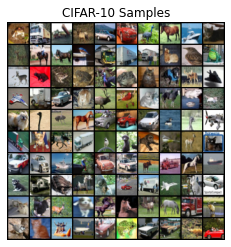

In [ ]:
visualize_q1_data()

 We'll use the CIFAR-10 architecture from the [SN-GAN paper](https://arxiv.org/pdf/1802.05957.pdf), with $z \in \mathbb R ^{128}$, with $z \sim \mathcal N (0, I_{128})$. Instead of upsampling via transposed convolutions and downsampling via pooling or striding, we'll use these DepthToSpace and SpaceToDepth methods for changing the spatial configuration of our hidden states. 

```
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]
        output = torch.stack(stack, 0).transpose(0, 1).permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width, s_depth)
        output = output.permute(0, 3, 1, 2)
        return output


class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output

# Spatial Upsampling with Nearest Neighbors
Upsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
    x = torch.cat([x, x, x, x], dim=1)
    DepthToSpace(block_size=2)
    Conv2d(in_dim, out_dim, kernel_size, stride=stride, padding=padding)


# Spatial Downsampling with Spatial Mean Pooling
Downsample_Conv2d(in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        SpaceToDepth(2)
        torch.sum(x.chunk(4, dim=1)) / 4.0
        nn.Conv2d(in_dim, out_dim, kernel_size,
                              stride=stride, padding=padding, bias=bias)
```

Here's pseudocode for how we'll implement a ResBlockUp, used in the generator:

```
ResnetBlockUp(x, in_dim, kernel_size=(3, 3), n_filters=256):
    _x = x
    _x = nn.BatchNorm2d(in_dim)(_x)
    _x = nn.ReLU()(_x)
    _x = nn.Conv2d(in_dim, n_filters, kernel_size, padding=1)(_x)
    _x = nn.BatchNorm2d(n_filters)(_x)
    _x = nn.ReLU()(_x)
    residual = Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1)(_x)
    shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)(x)
    return residual + shortcut
```
The ResBlockDown module is similar, except it uses Downsample_Conv2d and omits the BatchNorm.

Finally, here's the architecture for the generator:
```
def Generator(*, n_samples=1024, n_filters=128):
    z = Normal(0, 1)([n_samples, 128])
    nn.Linear(128, 4*4*256)
    reshape output of linear layer
    ResnetBlockUp(in_dim=256, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
    nn.BatchNorm2d(n_filters),
    nn.ReLU(),
    nn.Conv2d(n_filters, 3, kernel_size=(3, 3), padding=1),
    nn.Tanh()
```
Again, the discriminator has the same architecture, except with ResnetBlockDown and no BatchNorm.

**Hyperparameters**

We'll implement [WGAN-GP](https://arxiv.org/abs/1704.00028), which uses a gradient penalty to regularize the discriminator. Use the Adam optimizer with $\alpha = 2e-4$, $\beta_1 = 0$, $\beta_2 = 0.9$, $\lambda = 10$, $n_{critic} = 5$. Use a batch size of 256 and n_filters=128 within the ResBlocks. Train for at least 25000 gradient steps, with the learning rate linearly annealed to 0 over training. 

**You will provide the following deliverables**
1. Inception score (CIFAR-10 version) of the final model. We provide a utility that will automatically do this for you.
2. Discriminator loss across training
3. 100 samples. 

## Solution

In [12]:
import torch
from torch import nn
from torch.distributions import Normal, Uniform
from torch.optim import Adam
from torch.optim.lr_scheduler import LinearLR
from torch.utils.data import DataLoader
from tqdm import tqdm
import cv2

#### Generator

In [ ]:
class DepthToSpace(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, d_height, d_width, d_depth) = output.size()
        s_depth = int(d_depth / self.block_size_sq)
        s_width = int(d_width * self.block_size)
        s_height = int(d_height * self.block_size)
        t_1 = output.reshape(batch_size, d_height, d_width, self.block_size_sq, s_depth)
        spl = t_1.split(self.block_size, 3)
        stack = [t_t.reshape(batch_size, d_height, s_width, s_depth) for t_t in spl]

        output = torch.stack(stack, 0)
        output = output.transpose(0, 1)
        output = output.permute(0, 2, 1, 3, 4).reshape(batch_size, s_height, s_width, s_depth)
        output = output.reshape(batch_size, s_height, s_width, s_depth)
        output = output.permute(0, 3, 1, 2)

        return output


class Upsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.model = nn.Sequential(DepthToSpace(block_size=2),
                                   nn.Conv2d(in_dim, 
                                             out_dim, 
                                             kernel_size, 
                                             stride=stride, 
                                             padding=padding)) 

    def forward(self, x):
        x = torch.cat([x, x, x, x], dim=1)
        return self.model(x)

    
class ResnetBlockUp(nn.Module):
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=256):
        super().__init__()
        self.model = nn.Sequential(nn.BatchNorm2d(in_dim),
                                    nn.ReLU(),
                                    nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                                    nn.BatchNorm2d(n_filters),
                                    nn.ReLU(),
                                    Upsample_Conv2d(n_filters, n_filters, kernel_size, padding=1))
        
        self.shortcut = Upsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        _x = x
        residual = self.model(_x)  
        shortcut = self.shortcut(x)
        return residual + shortcut


class Generator(nn.Module):
    def __init__(self, n_filters=128):
        super().__init__()
        self.p_z = Normal(0, 1)
        self.start_stack = nn.Linear(128, 4*4*256)
        self.middle_stack = lambda x: x.reshape((-1, 256, 4, 4)) # reshape output of linear layer
        self.model = nn.Sequential(ResnetBlockUp(in_dim=256, n_filters=n_filters),
                                   ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                                   ResnetBlockUp(in_dim=n_filters, n_filters=n_filters),
                                   nn.BatchNorm2d(n_filters),
                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=n_filters, 
                                             out_channels=3, 
                                             kernel_size=(3, 3), 
                                             padding=1),
                                   nn.Tanh())

    def forward(self, n_samples=1_024):
        z = self.p_z.sample([n_samples, 128]).to(device)
        # print(z.shape)
        z = self.start_stack(z)
        # print(z.shape)
        z = self.middle_stack(z)
        # print(z.shape)
        z = self.model(z)
        # print(z.shape)
        return z



#### Discriminator

In [ ]:
class SpaceToDepth(nn.Module):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size
        self.block_size_sq = block_size * block_size

    def forward(self, input):
        output = input.permute(0, 2, 3, 1)
        (batch_size, s_height, s_width, s_depth) = output.size()
        d_depth = s_depth * self.block_size_sq
        d_width = int(s_width / self.block_size)
        d_height = int(s_height / self.block_size)
        t_1 = output.split(self.block_size, 2)
        stack = [t_t.reshape(batch_size, d_height, d_depth) for t_t in t_1]
        output = torch.stack(stack, 1)
        output = output.permute(0, 2, 1, 3)
        output = output.permute(0, 3, 1, 2)
        return output
       

class Downsample_Conv2d(nn.Module):
    def __init__(self, in_dim, out_dim, kernel_size=(3, 3), stride=1, padding=1):
        super().__init__()
        self.start_stack = SpaceToDepth(block_size=2)
        # self.middle_stack = lambda x: torch.sum(x.chunk(4, dim=1)) / 4.0
        self.middle_stack = lambda x: torch.stack(x.chunk(4, dim=1), dim=1).sum(dim=1) / 4.0
        self.model = nn.Conv2d(in_dim, 
                               out_dim, 
                               kernel_size,
                               stride=stride, 
                               padding=padding)
                            #  padding=padding, 
                            #  bias=False))

    def forward(self, x):
        # print(f"Downsample: {x.shape}")
        x = self.start_stack(x)
        # print(f"Downsample: {x.shape}")
        # print(x)
        x = self.middle_stack(x)
        # print(f"Downsample: {x.shape}")
        x = self.model(x)
        # print(f"Downsample: {x.shape}")
        return x


class ResnetBlockDown(nn.Module):
    '''
    The ResBlockDown module is similar, 
    except it uses Downsample_Conv2d and omits the BatchNorm.
    '''
    def __init__(self, in_dim, kernel_size=(3, 3), n_filters=3):
        super().__init__()
        self.model = nn.Sequential(nn.Conv2d(in_dim, n_filters, kernel_size, padding=1),
                                   nn.ReLU(),
                                   Downsample_Conv2d(n_filters, n_filters, kernel_size, padding=1))
        
        self.shortcut = Downsample_Conv2d(in_dim, n_filters, kernel_size=(1, 1), padding=0)

    def forward(self, x):
        _x = x
        # print(f"ResnetBlockDown 1: {x.shape}")
        residual = self.model(_x) 
        # print(f"ResnetBlockDown 2: {_x.shape}")
        shortcut = self.shortcut(x)
        # print(f"ResnetBlockDown 3: {_x.shape}")
        return residual + shortcut
        

class Discriminator(nn.Module):
    def __init__(self, n_filters=3):
        super().__init__()
        self.model = nn.Sequential(ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
                                   ResnetBlockDown(in_dim=n_filters, n_filters=n_filters),
                                   ResnetBlockDown(in_dim=n_filters, n_filters=256),
                                #    nn.ReLU())

                                   nn.ReLU(),
                                   nn.Conv2d(in_channels=256,  # maxpooling ? 
                                             out_channels=3, 
                                             kernel_size=(3, 3), 
                                             padding=1),
                                   nn.Tanh()) # ?

        # self.middle_stack = lambda x: x.reshape((-1, 256*4*4)) # reshape output of linear layer
        # self.finish_stack = nn.Linear(256*4*4, 1) # ReLu ?

        self.middle_stack = lambda x: x.reshape((-1, 3*4*4)) # reshape output of linear layer
        self.finish_stack = nn.Linear(3*4*4, 1) # ReLu ?

    def forward(self, x):
        # print(x.shape)
        x = self.model(x)
        # print(x.shape)
        x = self.middle_stack(x)
        # print(x.shape)
        x = self.finish_stack(x)
        return x

In [ ]:
# debug 0

# model = Generator().to(device)
# out = model(n_samples=10)
# print(out.shape)

# model_2 = Discriminator().to(device)
# out_2 = model_2(out)
# print(out_2.shape)

# out_2.device

In [ ]:
def interpolate(real, fake):
    eps = Uniform(0, 1).sample().to(device)
    return eps*real + (1 - eps)*fake


def convert(samples):
    samples = cv2.normalize(samples, None, 
                            alpha = 0, beta = 255, 
                            norm_type = cv2.NORM_MINMAX, 
                            dtype = cv2.CV_32F)
    return samples.astype(np.uint8) / 255.
    

class SN_WGAN_GP:

    def __init__(self, gen_n_filters=128, dis_n_filters=3, lmbd=10):
        '''
        - λ=10
        - ResBlocks: n_filters=128
        '''
        self.lmbd = lmbd
        self.gen = Generator(n_filters=gen_n_filters).to(device)
        self.dis = Discriminator(n_filters=dis_n_filters).to(device)


    def sample(self, n_samples=1_000):
        return self.gen(n_samples=n_samples)

    def compute_penalty(self, inter_score, inter):
        # print()
        # print(f"inter.shape: {inter.shape}")
        '''compute grad'''
        inter_score_grad = torch.autograd.grad(outputs=inter_score, 
                                               inputs=inter, 
                                               grad_outputs=torch.ones_like(inter_score))[0]    
        # print(f"inter_score_grad.shape: {inter_score_grad.shape}")

        '''compute norm'''
        batch_size = inter_score_grad.shape[0]
        inter_score_grad_norm = torch.norm(inter_score_grad.reshape(batch_size, -1), dim=1)
        # print(f"inter_score_grad_norm.shape: {inter_score_grad_norm.shape}")
        
        '''penalty'''
        penalty = (inter_score_grad_norm - 1)**2
        # print(f"penalty.shape: {penalty.shape}")

        return penalty


    def dis_loss(self, real, fake):
        inter = interpolate(real, fake)

        real_score = self.dis(real)
        fake_score = self.dis(fake)
        inter_score = self.dis(inter)

        # print(f"real_score.shape: {real_score.shape}")
        # print(f"fake_score.shape: {fake_score.shape}")
        # print(f"inter_score.shape: {inter_score.shape}")

        penalty = self.compute_penalty(inter_score, inter)

        dis_loss = -real_score.mean() + \
                    fake_score.mean() + \
                    penalty.mean() * self.lmbd

        return dis_loss


    def gen_loss(self, fake):
        fake_score = self.dis(fake)
        gen_loss = -fake_score.mean()
        return gen_loss


    def train(self, 
              train_data, 
              grad_steps=25_000, 
              batch_size=256, 
              alpha=2e-4, 
              beta_1=0, 
              beta_2=0.9,
              n_critic=5):
        '''
        We'll implement WGAN-GP, which uses a gradient penalty to regularize the discriminator:
        - Adam optimizer: α=2e−4, β1=0, β2=0.9
        - n_critic=5
        - batch size=256
        - gradient steps >= 25_000
        - lr linearly annealed to 0 over training
        '''
        num_epochs = int(grad_steps / batch_size)
        print(f"num_epochs: {num_epochs}")

        gen_grad_steps = int(grad_steps / n_critic)
        dis_grad_steps = int((n_critic - 1) * grad_steps / n_critic)

        gen_opt = Adam(self.gen.parameters(), lr=alpha, betas=(beta_1, beta_2))
        dis_opt = Adam(self.dis.parameters(), lr=alpha, betas=(beta_1, beta_2))
        
        gen_scheduler = LinearLR(gen_opt, start_factor=1, end_factor=0, total_iters=gen_grad_steps)
        dis_scheduler = LinearLR(dis_opt, start_factor=1, end_factor=0, total_iters=dis_grad_steps)

        dataloader = DataLoader(train_data, 
                                batch_size=batch_size,
                                shuffle=True)
        
        dis_losses = []
        gen_losses = []

        for epoch in range(num_epochs):
            print(f"Epoch: {epoch}")

            for i, batch in enumerate(tqdm(dataloader, desc="batches")):
                
                if i % n_critic != 0 or i == 0: # the very first iteration is for critic
                    '''discriminator update'''
                    real = batch.to(device)
                    fake = self.gen(n_samples=batch_size)

                    dis_loss = self.dis_loss(real, fake)
                    dis_opt.zero_grad()
                    dis_loss.backward()
                    dis_opt.step()
                    dis_scheduler.step() # here ?

                    dis_losses.append(dis_loss.item())

                else:
                    '''generator update'''
                    fake = self.gen(n_samples=batch_size)

                    gen_loss = self.gen_loss(fake)
                    gen_opt.zero_grad()
                    gen_loss.backward()
                    gen_opt.step()
                    gen_scheduler.step() # here ?

                    gen_losses.append(gen_loss.item())

            if len(dis_losses) > 0 and len(gen_losses) > 0:
                print(f"last dis_loss: {dis_losses[-1]} | last gen_loss: {gen_losses[-1]}")

        return dis_losses, gen_losses

In [ ]:
# ### debug 1

# MODEL = SN_WGAN_GP()
# imgs = MODEL.sample(n_samples=100)
# imgs = imgs.detach()
# print(imgs.device)

# dis_losses, gen_losses = MODEL.train(imgs, batch_size=10, grad_steps=20)
# # dis_losses, gen_losses = MODEL.train(imgs, batch_size=10, grad_steps=100)

In [ ]:
### debug 2

# train_data = load_q1_data()
# train_data = train_data.data.transpose((0, 3, 1, 2)) / 255.0

# print(train_data.dtype)
# _train_data = torch.from_numpy(train_data)
# print(_train_data.dtype)
# _train_data = _train_data.float()
# print(_train_data.dtype)

In [ ]:
# MODEL = SN_WGAN_GP()

# dis_losses, _ = MODEL.train(_train_data[:100], grad_steps=100, batch_size=10)
# samples = MODEL.sample(n_samples=1_000).detach().cpu().numpy().transpose((0, 2, 3, 1))
# samples = convert(samples)

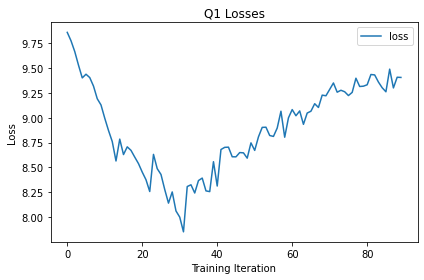

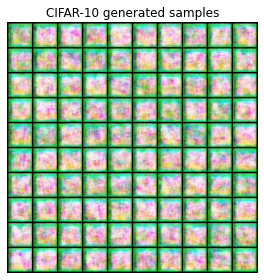

In [ ]:
plot_gan_training(dis_losses, 'Q1 Losses', 'results/q1_losses.png')

show_samples(samples[:100] * 255.0, 
             fname='results/q1_samples.png', 
             title=f'CIFAR-10 generated samples')

In [ ]:
def q1(train_data):
    """
    train_data: An (n_train, 3, 32, 32) numpy array of CIFAR-10 images with values in [0, 1]

    Returns
    - a (# of training iterations,) numpy array of WGAN critic train losses evaluated every minibatch
    - a (1000, 32, 32, 3) numpy array of samples from your model in [0, 1]. 
        The first 100 will be displayed, and the rest will be used to calculate the Inception score. 
    """

    '''
    Hyperparameters
    '''    
    gen_n_filters=128
    dis_n_filters=3
    lmbd=10
    # grad_steps=25_000
    # grad_steps=200
    grad_steps=2_560
    batch_size=256
    # batch_size=20
    alpha=2e-4
    beta_1=0
    beta_2=0.9
    n_critic=5
    n_samples=1_000

    train_data = torch.from_numpy(train_data).float()

    model = SN_WGAN_GP(gen_n_filters=gen_n_filters,
                       dis_n_filters=dis_n_filters,
                       lmbd=lmbd)

    dis_losses, _ = model.train(train_data,
    # dis_losses, _ = model.train(train_data[:200],
                                grad_steps=grad_steps,
                                batch_size=batch_size,
                                alpha=alpha,
                                beta_1=beta_1,
                                beta_2=beta_2,
                                n_critic=n_critic)

    samples = model.sample(n_samples=n_samples).detach().cpu().numpy().transpose((0, 2, 3, 1))
    samples = convert(samples)

    return dis_losses, samples

## Results

Files already downloaded and verified
num_epochs: 10
Epoch: 0


batches: 100%|██████████| 196/196 [04:56<00:00,  1.51s/it]


last dis_loss: 9.499094009399414 | last gen_loss: -0.36156249046325684
Epoch: 1


batches: 100%|██████████| 196/196 [04:55<00:00,  1.51s/it]


last dis_loss: 8.946414947509766 | last gen_loss: -0.040868066251277924
Epoch: 2


batches: 100%|██████████| 196/196 [04:55<00:00,  1.51s/it]


last dis_loss: 9.12417984008789 | last gen_loss: 0.048904672265052795
Epoch: 3


batches: 100%|██████████| 196/196 [04:55<00:00,  1.51s/it]


last dis_loss: 9.475630760192871 | last gen_loss: 0.05480619892477989
Epoch: 4


batches: 100%|██████████| 196/196 [04:55<00:00,  1.51s/it]


last dis_loss: 9.31468391418457 | last gen_loss: -0.3391033709049225
Epoch: 5


batches: 100%|██████████| 196/196 [04:55<00:00,  1.51s/it]


last dis_loss: 9.300278663635254 | last gen_loss: 0.10911355912685394
Epoch: 6


batches: 100%|██████████| 196/196 [04:55<00:00,  1.51s/it]


last dis_loss: 9.4969482421875 | last gen_loss: -0.36475670337677
Epoch: 7


batches: 100%|██████████| 196/196 [04:55<00:00,  1.51s/it]


last dis_loss: 9.589003562927246 | last gen_loss: -0.04491710290312767
Epoch: 8


batches: 100%|██████████| 196/196 [04:55<00:00,  1.51s/it]


last dis_loss: 9.439372062683105 | last gen_loss: -0.09879213571548462
Epoch: 9


batches: 100%|██████████| 196/196 [04:55<00:00,  1.51s/it]


last dis_loss: 9.644440650939941 | last gen_loss: -0.04606461524963379
..........Inception score: 1.2877699


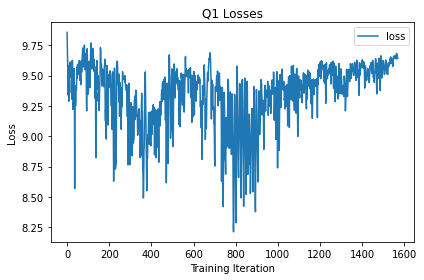

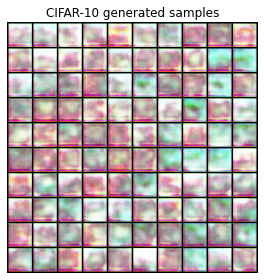

In [ ]:
q1_save_results(q1)

# Question 2: Representation Learning with BiGAN on MNIST

In this part, we train a BiGAN on the MNIST dataset. Execute the cell below to visualize the dataset.

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



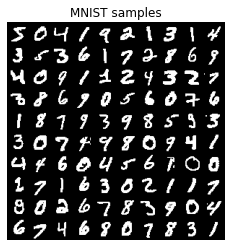

In [4]:
visualize_q2_data()

In BiGAN, in addition to training a generator $G$ and a discriminator $D$, we train an encoder $E$ that maps from real images $x$ to latent codes $z$. The discriminator now must learn to jointly identify fake $z$, fake $x$, and paired $(x, z)$ that don't belong together. In the original [BiGAN paper](https://arxiv.org/pdf/1605.09782.pdf), they prove that the optimal $E$ learns to invert the generative mapping $G: z \rightarrow x$. Our overall minimax term is now
$$V(D, E, G) = \mathbb{E}_{x \sim p_x}[\mathbb{E}_{z \sim p_E(\cdot | x)}[\log D(x, z)]] + \mathbb{E}_{z \sim p_z}[\mathbb{E}_{x \sim p_G(\cdot | z)}[\log (1 - D(x, z))]]$$

**Architecture**

We will closely follow the MNIST architecture outlined in the original BiGAN paper, Appendix C.1, with one modification: instead of having $z \sim \text{Uniform}[-1, 1]$, we use $z \sim \mathcal N (0, 1)$ with $z \in \mathbb R ^{50}$. 

**Hyperparameters**

We make several modifications to what is listed in the BiGAN paper. We apply $l_2$ weight decay to all weights and decay the step size $\alpha$ linearly to 0 over the course of training. Weights are initialized via the default PyTorch manner. We recommend training for at least 100 epochs -- this part is much less computationally expensive than previous homeworks. 

**Reconstructions**

You should take the first 20 images from the MNIST training set and then display the reconstructions $x_{recon} = G(E(x))$. It's ok if your reconstructions are somewhat lossy; ours are too. We will provide a utility to show these. 

**Testing the representation**

We want to see how good a linear classifier $L$ we can learn such that 
$$y \approx L(E(x))$$
where $y$ is the appropriate label. Fix $E$ and learn a weight matrix $W$ such that your linear classifier is composed of passing $x$ through $E$, then multiplying by $W$, then applying a softmax nonlinearity. Train this via gradient descent with the cross-entropy loss. 

As a baseline, randomly initialize another network $E_{random}$ with the same architecture, fix its weights, and train a linear classifier on top, as done in the previous part.


**You will provide the following deliverables**
1. Plot of the minimax loss term. 
2. 100 samples from the BiGAN
3. A comparison of MNIST images $x$ with their reconstructions $G(E(x))$.
4. Test loss plot for the linear classifier trained on the pretrained encoder, and a randomly initialized encoder. 
5. Final test losses for the two linear classifiers. 

**Feel free to train the networks separately, save the necessary information, and simply use our function to generate the appropriate figures.**


In [5]:
from tqdm import trange
from tqdm.notebook import tqdm as tqdm_notebook
from copy import deepcopy

from torch.optim.lr_scheduler import LambdaLR
from torchvision.utils import save_image

In [6]:
class GeneratorBiGAN(nn.Module):
    def __init__(self, latent_dim=50, flattened_dim=784):
        super(GeneratorBiGAN, self).__init__()
        self.a = int(flattened_dim**0.5)
        self.model = nn.Sequential(nn.Linear(latent_dim, 1024),
                                    nn.ReLU(),
                                    nn.Linear(1024, 1024),
                                    nn.BatchNorm1d(1024, affine=False),
                                    nn.ReLU(),
                                    nn.Linear(1024, flattened_dim),
                                    nn.Tanh())

    def forward(self, x):
        out = self.model(x)
        return out.reshape(x.shape[0], 1, self.a, self.a)


class DiscriminatorBiGAN(nn.Module):
    def __init__(self, latent_dim=50, flattened_dim=784):
        super(DiscriminatorBiGAN, self).__init__()
        self.model = nn.Sequential(nn.Linear(latent_dim + flattened_dim, 1024),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(1024, 1024),
                                    nn.BatchNorm1d(1024, affine=False),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(1024, 1),
                                    nn.Sigmoid())

    def forward(self, z, x):
        zx = torch.cat((z, x), dim=1)
        return self.model(zx)


class EncoderBiGAN(nn.Module):
    def __init__(self, latent_dim=50, flattened_dim=784):
        super(EncoderBiGAN, self).__init__()
        self.latent_dim = latent_dim
        self.model = nn.Sequential(nn.Linear(flattened_dim, 1024),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(1024, 1024),
                                    nn.BatchNorm1d(1024, affine=False),
                                    nn.LeakyReLU(0.2),
                                    nn.Linear(1024, latent_dim))

    def forward(self, x):
        x = x.view(x.shape[0], -1)
        return self.model(x)

In [7]:
class BiGAN(object):

    def __init__(self, latent_dim=50, flattened_dim=784):
        self.latent_dim = latent_dim
        self.dis = DiscriminatorBiGAN(latent_dim, flattened_dim).to(device)
        self.gen = GeneratorBiGAN(latent_dim, flattened_dim).to(device)  
        self.enc = EncoderBiGAN(latent_dim, flattened_dim).to(device) 


    def sample(self, n_samples=100, filename=None):
        self.gen.eval()
        a = self.gen.a
        with torch.no_grad():
            z = (torch.rand(n_samples, self.latent_dim).to(device) - 0.5) * 2
            samples = self.gen(z).reshape(-1, 1, a, a)
            if filename is not None:
                save_image(samples, filename, nrow=10, normalize=True)
            else:
                return samples.to('cpu').detach().numpy()


    def reconstruct(self, x):
        self.gen.eval()
        self.enc.eval()
        a = self.gen.a
        with torch.no_grad():
            z = self.enc(x)
            recons = self.gen(z).reshape(-1, 1, a, a)
        return recons.to('cpu').detach().numpy()


    def dis_loss(self, x):
        batch_size = x.shape[0]
        mean = torch.zeros(batch_size, self.latent_dim)
        std = torch.ones(batch_size, self.latent_dim)

        z_fake = torch.normal(mean, std).to(device)
        z_real = self.enc(x).reshape(batch_size, self.latent_dim)

        x_fake = self.gen(z_fake).reshape(batch_size, -1)
        x_real = x.view(batch_size, -1)

        fake_score = self.dis(z_fake, x_fake)
        real_score = self.dis(z_real, x_real)

        d_loss = - 0.5 * (real_score).log().mean() \
                 - 0.5 * (1 - fake_score).log().mean()

        return d_loss


    def train(self, 
              train_loader, 
              test_loader, 
              n_epochs=100,  
              lr=2e-4, 
              betas=(0.5, 0.999),
              weight_decay=2.5e-5):
        
        dis_opt = Adam(self.dis.parameters(), 
                            lr=lr, 
                            betas=betas, 
                            weight_decay=weight_decay)
        
        gen_opt = Adam(list(self.enc.parameters()) + list(self.gen.parameters()), 
                       lr=lr, 
                       betas=betas, 
                       weight_decay=weight_decay)
        
        dis_scheduler = LambdaLR(dis_opt,
                                 lambda epoch: (n_epochs - epoch) / n_epochs,
                                 last_epoch=-1)
        
        gen_scheduler = LambdaLR(gen_opt,
                                 lambda epoch: (n_epochs - epoch) / n_epochs,
                                 last_epoch=-1)

        train_losses = []
        for epoch in tqdm_notebook(range(n_epochs), desc='Epoch'):

            self.dis.train()
            self.gen.train()
            self.enc.train()
            dis_losses = []

            for i, (x, y) in enumerate(tqdm_notebook(train_loader, 
                                                     desc='batches', 
                                                     leave=False)):
                x = x.to(device).float()

                '''discriminator'''
                dis_opt.zero_grad()
                dis_loss = self.dis_loss(x)
                dis_loss.backward()
                dis_opt.step()

                '''generator'''
                gen_opt.zero_grad()
                gen_loss = -self.dis_loss(x) # ???
                gen_loss.backward()
                gen_opt.step()

                dis_losses.append(dis_loss.item())

            gen_scheduler.step()
            dis_scheduler.step()
            train_losses.append(np.mean(dis_losses))
            self.sample(n_samples=100, filename=f'epoch_{epoch}_samples.png')

        np.save("train_losses.npy", np.array(train_losses))
        self.save_models('weights.pt')

        return np.array(train_losses)


    '''utils'''
    def save_models(self, filename):
        torch.save(self.gen.state_dict(), "gen_" + filename)
        torch.save(self.dis.state_dict(), "dis_" + filename)
        torch.save(self.enc.state_dict(), "enc_" + filename)

    def load_models(self, filename):
        self.gen.load_state_dict(torch.load("gen_" + filename))
        self.dis.load_state_dict(torch.load("dis_" + filename))
        self.enc.load_state_dict(torch.load("enc_" + filename))

        

In [8]:
class LinearClassifier(object):

    def __init__(self, encoder, num_classes=10):
        self.encoder = encoder
        self.linear = nn.Linear(encoder.latent_dim, num_classes).to(device)


    def train(self, train_loader, test_loader, n_epochs=50, lr=1e-3):

        opt = Adam(self.linear.parameters(), lr=lr)

        train_losses = []
        val_accs = []

        for epoch in tqdm_notebook(range(n_epochs), desc='Epoch'):

            self.encoder.eval()
            self.linear.train()

            train_loss = []

            for i, (x, y) in enumerate(tqdm_notebook(train_loader, 
                                                     desc='batches', 
                                                     leave=False)):
                x = x.to(device).float()
                y = y.to(device)

                opt.zero_grad()
                z = self.encoder(x).detach()
                pred = self.linear(z)
                linear_loss = F.cross_entropy(pred, y)
                linear_loss.backward()
                opt.step()

                train_loss.append(linear_loss.item())
            val_acc = self.val_acc(test_loader)
            val_accs.append(val_acc)
            train_losses.append(np.mean(train_loss))

        np.save("train_losses.npy", np.array(train_losses))
        return np.array(train_losses), np.array(val_accs)


    def val_acc(self, test_loader):
        self.encoder.eval()
        self.linear.eval()

        val_acc_total = 0
        val_items = 0

        with torch.no_grad():
            for (inputs, labels) in test_loader:
                inputs = inputs.to(device).float()
                z = self.encoder(inputs)
                labels = labels.to(device)
                logits = self.linear(z)
                predictions = torch.argmax(logits, dim=1)
                num_correct = torch.sum(predictions == labels).float()
                val_acc_total += num_correct
                val_items += inputs.shape[0]

        return (val_acc_total / val_items).to('cpu').detach().numpy()

In [9]:
def create_loaders(train_data, test_data, batch_size=256):
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

def get_pairs(gan, train_data, a=28):
    train_images = train_data.data[:20].reshape(20, 1, a, a) / 255.0
    train_img_tensor = torch.FloatTensor(train_images).to(device) * 2 - 1
    recons = gan.reconstruct(train_img_tensor) * 0.5 + 0.5
    return np.concatenate([train_images, recons], axis=0).transpose(0, 2, 3, 1)

## Solution

In [10]:
def q2(train_data, test_data):
    """
    train_data: A PyTorch dataset that contains (n_train, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST
    test_data: A PyTorch dataset that contains (n_test, 28, 28) MNIST digits, normalized to [-1, 1]
                Documentation can be found at torchvision.datasets.MNIST

    Returns
    - a (# of training iterations,) numpy array of BiGAN minimax losses evaluated every minibatch
    - a (100, 28, 28, 1) numpy array of BiGAN samples that lie in [0, 1]
    - a (40, 28, 28, 1) numpy array of 20 real image / reconstruction pairs
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on the BiGAN encoder evaluated every epoch 
    - a (# of training epochs,) numpy array of supervised cross-entropy losses on a random encoder evaluated every epoch 
    """

    latent_dim = 50
    # batch_size = 128
    batch_size = 10
    # gan_epochs = 100
    # class_epochs = 50
    gan_epochs = 10
    class_epochs = 5

    train_data.data = train_data.data[:1000]
    test_data.data = test_data.data[:1000]
    train_data.targets = train_data.targets[:1000]
    test_data.targets = test_data.targets[:1000]

    train_loader, test_loader = create_loaders(train_data, 
                                               test_data, 
                                               batch_size=batch_size)

    gan = BiGAN(latent_dim=latent_dim)
    random_encoder = deepcopy(gan.enc)

    print("--- Classifier: random encoder ---")
    random_classifier = LinearClassifier(random_encoder)
    rand_class_train_losses, rand_class_val_accs = random_classifier.train(train_loader, 
                                                                           test_loader, 
                                                                           n_epochs=class_epochs)
    
    print("--- Train BiGAN ---")
    bigan_losses = gan.train(train_loader, test_loader, n_epochs=gan_epochs)
    bigan_encoder = deepcopy(gan.enc)

    print("--- Classifier: BiGAN encoder ---")
    bigan_classifier = LinearClassifier(bigan_encoder)
    bigan_class_train_losses, bigan_class_val_accs = bigan_classifier.train(train_loader, 
                                                                            test_loader, 
                                                                            n_epochs=class_epochs)

    '''samples'''
    samples = gan.sample(n_samples=100).transpose(0, 2, 3, 1) * 0.5 + 0.5
    pairs = get_pairs(gan, train_data)

    print(f"Val acc - random: {rand_class_val_accs[-1]}")
    print(f"Val acc - BiGAN: {bigan_class_val_accs[-1]}")

    return bigan_losses, samples, pairs, bigan_class_train_losses, rand_class_train_losses
   

## Results

--- Classifier: random encoder ---


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

--- Train BiGAN ---


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

--- Classifier: BiGAN encoder ---


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

batches:   0%|          | 0/100 [00:00<?, ?it/s]

Val acc - random: 0.2760000228881836
Val acc - BiGAN: 0.5460000038146973


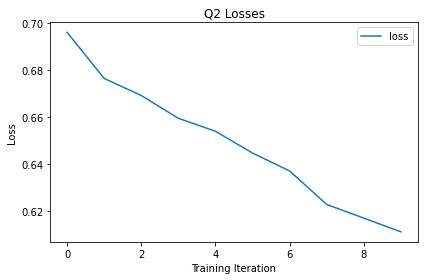

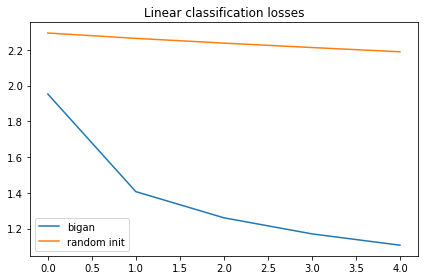

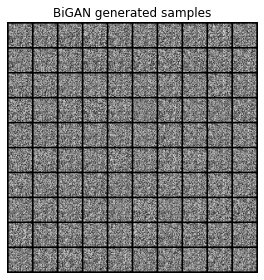

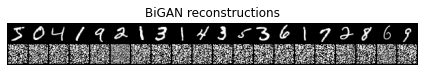

BiGAN final linear classification loss: 1.1066802096366883
Random encoder linear classification loss: 2.188809857368469


In [13]:
q2_save_results(q2)

# Bonus 5: CycleGAN
In this question, you'll train a CycleGAN model to learn to translate between two different image domains, without any paired data. Execute the following cell to visualize our two datasets: MNIST and Colored MNIST. 

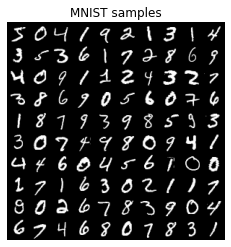

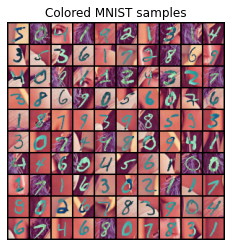

In [ ]:
visualize_cyclegan_datasets()

In [CycleGAN](https://arxiv.org/pdf/1703.10593.pdf), the goal is to learn functions $F$ and $G$ that can transform images from $X \rightarrow Y$ and vice-versa. This is an unconstrained problem, so we additionally enforce the *cycle-consistency* property, where we want 
$$x \approx G(F(x))$$
and  
$$y \approx F(G(x))$$
This loss function encourages $F$ and $G$ to approximately invert each other. In addition to this cycle-consistency loss, we also have a standard GAN loss such that $F(x)$ and $G(y)$ look like real images from the other domain. 

Since this is a bonus question, we won't do much hand-holding. We recommend reading through the original paper to get a sense of what architectures and hyperparameters are useful. Note that our datasets are fairly simple, so you won't need excessively large models. 

**You will report the following deliverables**
1. A set of images showing real MNIST digits, transformations of those images into Colored MNIST digits, and reconstructions back into the greyscale domain. 
2. A set of images showing real Colored MNIST digits, transformations of those images, and reconstructions. 

## Solution

In [ ]:
def b5(mnist_data, cmnist_data):
    """
    mnist_data: An (60000, 1, 28, 28) numpy array of black and white images with values in [0, 1]
    cmnist_data: An (60000, 3, 28, 28) numpy array of colored images with values in [0, 1]

    Returns
    - a (20, 28, 28, 1) numpy array of real MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of translated Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of reconstructed MNIST digits, in [0, 1]

    - a (20, 28, 28, 3) numpy array of real Colored MNIST digits, in [0, 1]
    - a (20, 28, 28, 1) numpy array of translated MNIST digits, in [0, 1]
    - a (20, 28, 28, 3) numpy array of reconstructed Colored MNIST digits, in [0, 1]
    """
    """ YOUR CODE HERE """

## Results

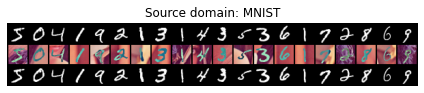

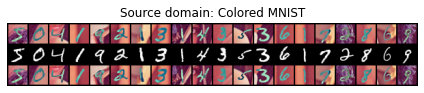

In [ ]:
b5_save_results(b5)